Loading data...
Cleaning data...
Creating RFM features...
Creating target variable...
Performing EDA...


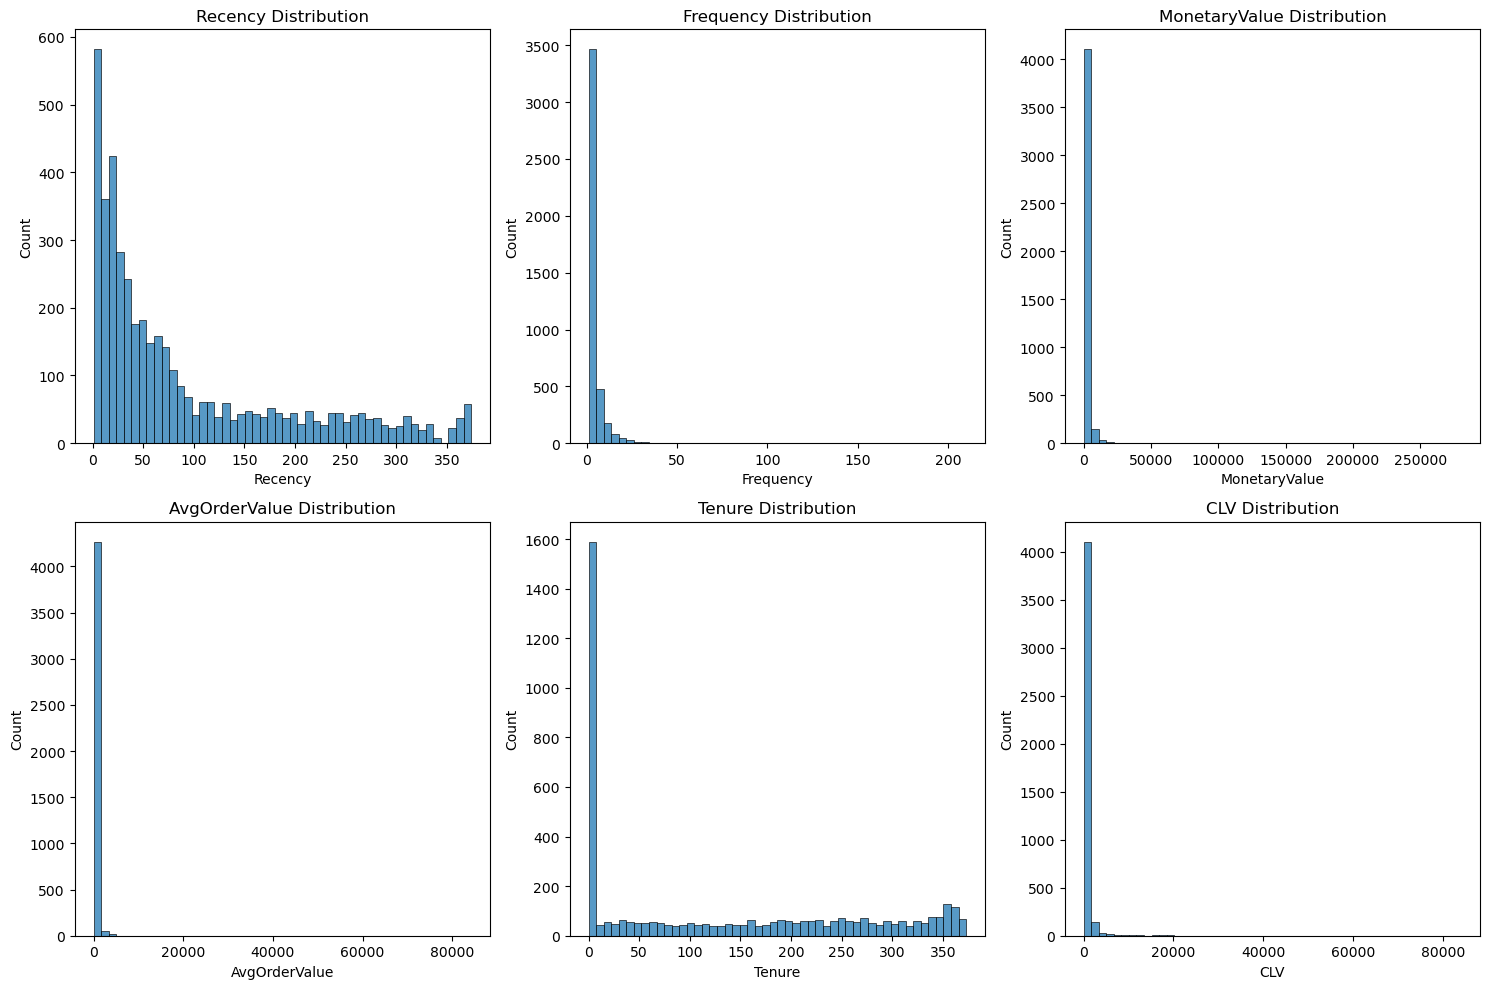

Preparing modeling data...
Building model pipeline...
Training model...
Evaluating model...
RMSE: 578.36
MAE: 36.88
R2 Score: 0.96
Plotting feature importance...


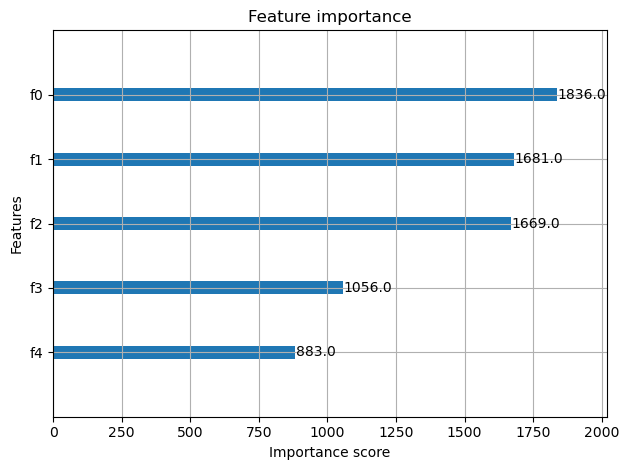

Saving model...
Model training complete!


In [1]:
# %% [markdown]
# # Customer Lifetime Value Prediction Model
# 
# This notebook covers:
# - Data loading and cleaning
# - Feature engineering
# - Model training
# - Model evaluation
# - Model saving

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# %%
# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
MODEL_PATH = 'clv_model.pkl'
SCALER_PATH = 'scaler.pkl'

# %%
# Load data
print("Loading data...")
df = pd.read_csv('data.csv',encoding='cp1252', parse_dates=['InvoiceDate'])

# %%
# Data cleaning
print("Cleaning data...")
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df = df[df['Quantity'] > 0]  # Remove returns

# %%
# Feature engineering - RFM
print("Creating RFM features...")
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'MonetaryValue'
})

# Additional features
rfm['AvgOrderValue'] = rfm['MonetaryValue'] / rfm['Frequency']
rfm['PurchaseFrequency'] = rfm['Frequency'] / ((snapshot_date - df.groupby('CustomerID')['InvoiceDate'].min()).dt.days)
rfm['Tenure'] = (df.groupby('CustomerID')['InvoiceDate'].max() - 
                 df.groupby('CustomerID')['InvoiceDate'].min()).dt.days

# %%
# Create target variable (6-month CLV)
# In production, you would use historical data with proper time windows
print("Creating target variable...")
rfm['CLV'] = rfm['MonetaryValue'] * 0.3  # Placeholder - replace with real calculation

# %%
# EDA
print("Performing EDA...")
plt.figure(figsize=(15, 10))

features = ['Recency', 'Frequency', 'MonetaryValue', 'AvgOrderValue', 'Tenure', 'CLV']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(rfm[feature], bins=50)
    plt.title(f'{feature} Distribution')
    
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# %%
# Prepare modeling data
print("Preparing modeling data...")
X = rfm[['Recency', 'Frequency', 'MonetaryValue', 'AvgOrderValue', 'Tenure']]
y = rfm['CLV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# %%
# Create pipeline with scaling and model
print("Building model pipeline...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# %%
# Train model
print("Training model...")
pipeline.fit(X_train, y_train)

# %%
# Evaluate model
print("Evaluating model...")
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# %%
# Feature importance
print("Plotting feature importance...")
xgb_model = pipeline.named_steps['model']
xgb.plot_importance(xgb_model)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# %%
# Save model
print("Saving model...")
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(pipeline, f)

print("Model training complete!")